In [1]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *

tf.config.run_functions_eagerly(True)

2022-05-17 10:42:50.244172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 10:42:50.244202: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [5]:
qubit_levels = [4, 4]
qubit_frequencies = [5e9, 4.1e9]
anharmonicities = [-300e6, -250e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]

In [6]:
# labels for all states
level_labels = []
level_labels_with_leakage = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels.append(None)
        else:
            level_labels.append(f"{i},{j}")
        level_labels_with_leakage.append(f"{i},{j}")

for i,l in enumerate(level_labels):
    print(i, l, level_labels_with_leakage[i])

0 0,0 0,0
1 0,1 0,1
2 0,2 0,2
3 0,3 0,3
4 1,0 1,0
5 1,1 1,1
6 1,2 1,2
7 1,3 1,3
8 2,0 2,0
9 2,1 2,1
10 2,2 2,2
11 2,3 2,3
12 3,0 3,0
13 3,1 3,1
14 3,2 3,2
15 3,3 3,3


In [7]:
# find energy eigenvalues and eigenvectors
qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                      t2stars, qubit_temps)
model = Mdl(qubits, [])
model.set_lindbladian(False)
model.set_dressed(False)
model.set_FR(False)
H = model.get_Hamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)
print(evals, len(evals))

[0.000e+00 4.100e+09 7.950e+09 1.155e+10 5.000e+09 9.100e+09 1.295e+10
 1.655e+10 9.700e+09 1.380e+10 1.765e+10 2.125e+10 1.410e+10 1.820e+10
 2.205e+10 2.565e+10] 16


2022-05-17 10:42:57.046635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 10:42:57.046823: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 10:42:57.046862: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist


In [8]:
#energies = H.diagonal().real / (2*np.pi)
#labels = []
#for i in range(qubit_levels[0]):
#    for j in range(qubit_levels[1]):
#        idx = i * qubit_levels[0] + j
#        labels.append(f"{i},{j}")
#        print(labels[idx], energies[idx])
#indices = np.argsort(energies)

# find labels corresponding to states
stateEnergies = []
stateLabels = []
for i, x in enumerate(level_labels_with_leakage):
    #if level_labels[i] is not None:
    energy = evals[i]
    stateEnergies.append(energy)
    stateLabels.append(x)

for i in range(len(stateEnergies)):
    print(i, stateLabels[i], stateEnergies[i])

0 0,0 0.0
1 0,1 4100000000.0
2 0,2 7950000000.0
3 0,3 11549999999.999998
4 1,0 5000000000.0
5 1,1 9099999999.999998
6 1,2 12950000000.0
7 1,3 16549999999.999998
8 2,0 9700000000.000002
9 2,1 13800000000.000004
10 2,2 17650000000.000004
11 2,3 21250000000.0
12 3,0 14099999999.999996
13 3,1 18199999999.999996
14 3,2 22050000000.0
15 3,3 25649999999.999996


In [9]:
# list all transitions
sortedEnergiesLabels = sorted(zip(stateEnergies, stateLabels), key=lambda x: x[0])
transitionEnergies = []
transitionLabels = []
transitionStateIndices = []
for i in range(len(sortedEnergiesLabels)):
    for j in range(len(sortedEnergiesLabels)):
        if i != j:
            E = sortedEnergiesLabels[j][0] - sortedEnergiesLabels[i][0]
            if E > 0:
                transitionEnergies.append(E)
                transitionLabels.append(sortedEnergiesLabels[i][1] + " - " + sortedEnergiesLabels[j][1])
                transitionStateIndices.append((i, j))

for i in range(len(transitionEnergies)):
    print(i, transitionLabels[i], transitionStateIndices[i], transitionEnergies[i])

0 0,0 - 0,1 (0, 1) 4100000000.0
1 0,0 - 1,0 (0, 2) 5000000000.0
2 0,0 - 0,2 (0, 3) 7950000000.0
3 0,0 - 1,1 (0, 4) 9099999999.999998
4 0,0 - 2,0 (0, 5) 9700000000.000002
5 0,0 - 0,3 (0, 6) 11549999999.999998
6 0,0 - 1,2 (0, 7) 12950000000.0
7 0,0 - 2,1 (0, 8) 13800000000.000004
8 0,0 - 3,0 (0, 9) 14099999999.999996
9 0,0 - 1,3 (0, 10) 16549999999.999998
10 0,0 - 2,2 (0, 11) 17650000000.000004
11 0,0 - 3,1 (0, 12) 18199999999.999996
12 0,0 - 2,3 (0, 13) 21250000000.0
13 0,0 - 3,2 (0, 14) 22050000000.0
14 0,0 - 3,3 (0, 15) 25649999999.999996
15 0,1 - 1,0 (1, 2) 900000000.0
16 0,1 - 0,2 (1, 3) 3850000000.0
17 0,1 - 1,1 (1, 4) 4999999999.999998
18 0,1 - 2,0 (1, 5) 5600000000.000002
19 0,1 - 0,3 (1, 6) 7449999999.999998
20 0,1 - 1,2 (1, 7) 8850000000.0
21 0,1 - 2,1 (1, 8) 9700000000.000004
22 0,1 - 3,0 (1, 9) 9999999999.999996
23 0,1 - 1,3 (1, 10) 12449999999.999998
24 0,1 - 2,2 (1, 11) 13550000000.000004
25 0,1 - 3,1 (1, 12) 14099999999.999996
26 0,1 - 2,3 (1, 13) 17150000000.0
27 0,1 - 3,

In [10]:
def getEnergies(couplingStrength: float) -> np.array:
    # Initialise the qubits and drive lines
    qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                          t2stars, qubit_temps)
    coupling = createChainCouplings([couplingStrength], qubits)

    # Create the model
    model = Mdl(qubits, coupling)
    model.set_lindbladian(False)
    model.set_dressed(False)
    model.set_FR(False)

    # all energy levels with labels
    H = model.get_Hamiltonian().numpy()
    evals,evecs = scipy.linalg.eig(H)
    return evals.real / (2 * np.pi)

In [11]:
couplings = np.linspace(0, 100e6, 100)
#allEnergies = getEnergies(couplings[0])
#allEnergies = np.reshape(allEnergies, (25,1))
allEnergies = np.empty(shape=(16,0))
for coupling in couplings:
    print(coupling)
    energies = getEnergies(coupling)
    energies = np.sort(energies)
    allEnergies = np.append(allEnergies, np.reshape(energies, (16,1)), axis=1)

0.0
1010101.0101010101
2020202.0202020202
3030303.0303030303
4040404.0404040404
5050505.05050505
6060606.060606061
7070707.070707071
8080808.080808081
9090909.09090909
10101010.1010101
11111111.111111112
12121212.121212121
13131313.13131313
14141414.141414141
15151515.151515152
16161616.161616161
17171717.17171717
18181818.18181818
19191919.191919193
20202020.2020202
21212121.21212121
22222222.222222224
23232323.232323233
24242424.242424242
25252525.25252525
26262626.26262626
27272727.272727273
28282828.282828283
29292929.29292929
30303030.303030305
31313131.313131314
32323232.323232323
33333333.333333332
34343434.34343434
35353535.353535354
36363636.36363636
37373737.37373737
38383838.383838385
39393939.39393939
40404040.4040404
41414141.41414142
42424242.42424242
43434343.434343435
44444444.44444445
45454545.45454545
46464646.464646466
47474747.47474747
48484848.484848484
49494949.4949495
50505050.5050505
51515151.515151516
52525252.52525252
53535353.535353534
54545454.54545455
55555

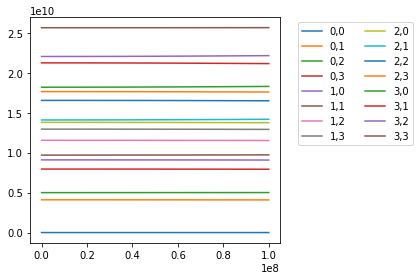

In [12]:
plt.figure()
y = allEnergies.T
#plt.plot(couplings, y, '.', color='black', markersize=1)
plt.plot(couplings, y)
plt.legend(
    stateLabels,
    ncol=int(np.ceil(16 / 15)),
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
)
plt.tight_layout()
#plt.savefig('energies-couplings.svg')
plt.show()

0,1 - 1,0 500000000.0000038 510099273.46540356
0,2 - 1,1 750000000.0 740170721.2916946
0,2 - 2,0 949999999.9999981 980167983.1821384
1,1 - 2,0 199999999.9999981 239997261.8904438
0,3 - 1,2 999999999.9999847 991257880.8874397
1,2 - 3,0 350000000.00001144 322940247.1721935
1,2 - 2,1 450000000.00001526 531483466.37831306
3,0 - 2,1 100000000.00000381 208543219.20611954
1,3 - 2,2 700000000.0000191 667977792.9411049
1,3 - 3,1 850000000.0 944984336.84095
2,2 - 3,1 149999999.99998093 277006543.8998451
2,3 - 3,2 400000000.0000229 501819741.86086655


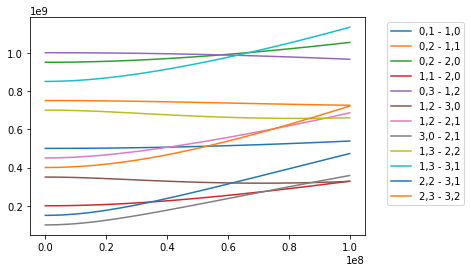

In [16]:
#selectedTransitions = [1, 26, 72, 133] #[1, 26, 49, 94, 112, 184] #[67, 101]#1, 17, 31, 58
selectedTransitions = list(range(len(transitionStateIndices)))

plt.figure()
for t in selectedTransitions:
    index = transitionStateIndices[t]
    data1 = allEnergies[index[0]]
    data2 = allEnergies[index[1]]
    diff = data2 - data1
    if diff[0] < 1.2e9:
        plt.plot(couplings, diff, label=transitionLabels[t])
        print(transitionLabels[t], diff[0], diff[int(len(diff)/2)])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()